## Make Sea Surface Height from CDIP buoy spectrum

#### Notebook to create a realistic sea surface height for SWOT error analysis based on Curtis' request.
You can get the data from the CDIP thredds server:
http://thredds.cdip.ucsd.edu/thredds/catalog/cdip/archive/029p1/catalog.html?dataset=CDIP_Archive/029p1/029p1_historic.nc

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from scipy.interpolate import griddata
import time
import xarray as xr

from getmem import GetMem # I wrote this function. It's in the getmem.py file
from plot_dirSpec import  plot_dirSpec

In [2]:
nc = Dataset('data/029p1_historic.nc', 'r')

In [3]:
tp = nc.variables['waveTp'][:]
freq = nc.variables['waveFrequency'][:]
energy_density = nc.variables['waveEnergyDensity'][:]

I picked this time stamp because I had already looked at this event for other project. You can choose a different one. I'd advise against picking the highest peak perid since it might be an outlier.

In [4]:
ts =  393498 # time stamp
g = 9.8 # gravity
kp = ((2*np.pi/tp[ts])**2)/g
print('Peak Period = {:.3f} s'.format(tp[ts]))
print('Peak wavelenght = {:.3f} m'.format(2*np.pi/kp))

Peak Period = 18.182 s
Peak wavelenght = 515.609 m


In [5]:
E0 = energy_density[ts]

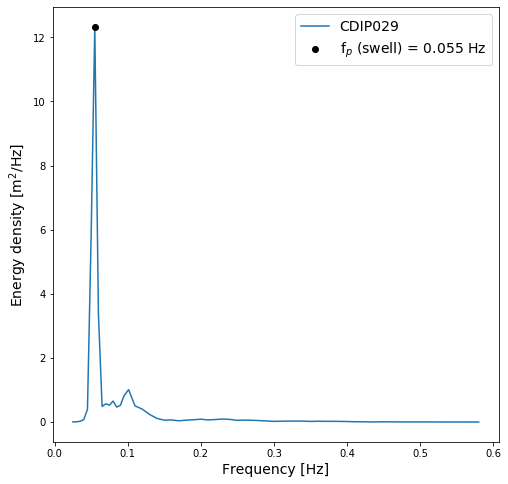

In [6]:
fp = freq[E0==E0.max()][0]
plt.figure(figsize=(8,8))
#plt.plot(freq, E0, label='CDIP029 {0}'.format(time[ts]))
plt.plot(freq, E0, label='CDIP029')
plt.plot(fp, E0[E0==E0.max()], 'ok', label='f$_p$ (swell) = {:.3f} Hz'.format(fp))
plt.ylabel("Energy density [m$^2$/Hz]", fontsize=14)
plt.xlabel("Frequency [Hz]", fontsize=14)
plt.legend(fontsize=14)

Load spectral momments

In [7]:
a1 = nc.variables['waveA1Value'][:][ts]
b1 = nc.variables['waveB1Value'][:][ts]
a2 = nc.variables['waveA2Value'][:][ts]
b2 = nc.variables['waveB2Value'][:][ts]

Now, we can reconstruct the directional distribution using the Method of Maximum Entropy. This
uses the module GetMem available onthe file getmem.py

In [8]:
ndir = 96 # number of direction bins
E = np.tile(E0, (ndir,1)).T
norm_mem= GetMem(a1,b1,a2,b2, ndir=ndir) # This uses the auxiliary function GetMem from getmem.py
dirSpec = E*norm_mem
dirSpec = dirSpec.T

In [9]:
theta = np.linspace(0, 2*np.pi, ndir)
K = ((2*np.pi*freq)**2)/g # uses the dispersion relation to go from frequency to wavenumber
KK, DD = np.meshgrid(K, theta)

Text(0.5, 0, 'Wavenumber [rad/m]')

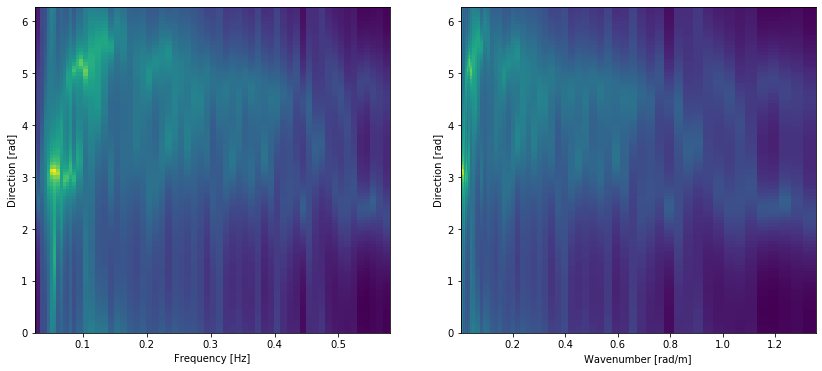

In [10]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.pcolormesh(freq, theta, np.log10(dirSpec))
plt.ylabel('Direction [rad]')
plt.xlabel('Frequency [Hz]')
plt.subplot(122)
plt.pcolormesh(KK, DD, np.log10(dirSpec))
plt.ylabel('Direction [rad]')
plt.xlabel('Wavenumber [rad/m]')

Now, we need to transform from $(\theta, k)$ to $(k_x, k_y)$. Everything below is used for constructing a regular grid to interpolate the data onto. N is the number of points, which will determine the size of the domain in physical space. L = N*dx/2. Also note that I hold until the end to deal with spectral normalizations since units don't matter for this purpose.

In [11]:
N = 10000 # number of grid points for the new grid
dx = 5 #Assumes 5 m sampling. Change it if you'd like to resolve higher wavenumbers 
Kx = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(N, dx))
Ky = Kx
ky_grid, kx_grid = np.meshgrid(Ky, Kx)
k_grid = (kx_grid**2 + ky_grid**2)**.5
theta_grid = np.arctan2(ky_grid, kx_grid)
theta_grid[theta_grid<0] = theta_grid[theta_grid<0]+2*np.pi

In [12]:
points = (DD.flatten(), KK.flatten()) # Original coordinates
values = dirSpec.flatten() # Data in the original coordinates
xi = (theta_grid.flatten(), k_grid.flatten()) # Target grid points
cart_grid = griddata(points, values, xi, method='linear')
Ekxky = cart_grid.reshape(k_grid.shape)

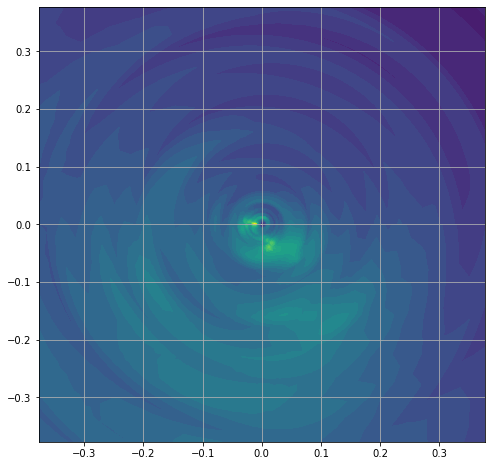

In [13]:
# Lots of points. Plot only a range of wavenumbers
nw=2000
plt.figure(figsize=(8, 8))
plt.contourf(kx_grid[nw:-nw, nw:-nw], ky_grid[nw:-nw, nw:-nw], 
             np.log10(Ekxky[nw:-nw, nw:-nw]), 30)
plt.grid()

In [14]:
Ekxky[np.isnan(Ekxky)] = 0 # Zeroing the amplitude at wavenumbers higher than k_max
rand_seed = np.random.RandomState(7)
pha = 2*np.pi*(2*rand_seed.rand(*Ekxky.shape) - 1)
F_hat = (np.cos(pha) + 1j*np.sin(pha))*Ekxky**.5 # assings random phase
F_hat = np.fft.fftshift(F_hat)
eta = np.fft.ifft2(F_hat, axes=(0,1))
eta = eta.real

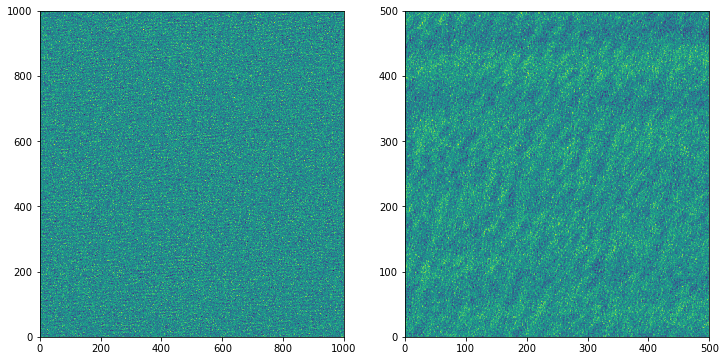

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.pcolormesh(eta[::10,::10])
plt.subplot(122)
plt.pcolormesh(eta[:500, :500])

In [16]:
# Normalize to desired significant wave height
hs = 4.3
eta_norm = hs*eta.real/eta.std()/4

In [17]:
x = np.arange(0, N*dx, dx)
ssh = xr.DataArray(data=eta_norm, dims=['y', 'x'],
                  coords=dict(x=x, y=x))

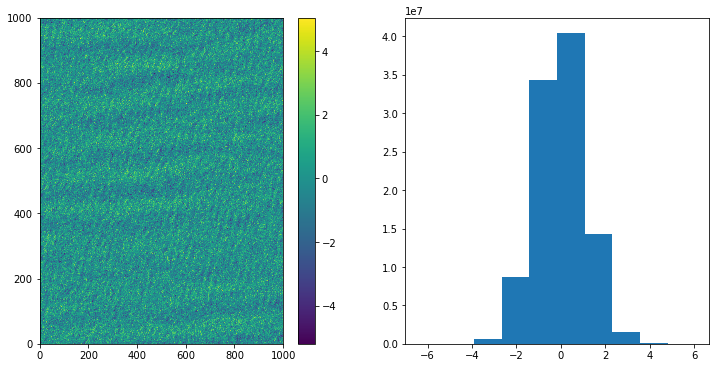

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.pcolormesh(ssh[:1000, :1000])
plt.colorbar()
plt.subplot(122)
h = plt.hist(ssh.values.flatten())

In [19]:
ssh.x.attrs['units'] = 'm'
ssh.x.attrs['long_name'] = 'distance in the x direction'
ssh.y.attrs['units'] = 'm'
ssh.y.attrs['long_name'] = 'distance in the y direction'

ds = xr.Dataset()
ds['sea_surface_height'] = ssh
ds.sea_surface_height.attrs['units'] = 'm'
ds.sea_surface_height.attrs['long_name'] = 'sea surface height'
ds.attrs['creator'] = 'Bia Villas Boas'
ds.attrs['data_created'] = time.ctime()
ds.attrs['significant_wave_height'] = '{:.3f} m'.format(4*ssh.std().values)
ds.attrs['peak_wavelenght'] = '500 m'

In [20]:
#ds.to_netcdf('/Users/villasboas/Desktop/long_swell_ssh.nc')